[INFO] Loading dataset...
[INFO] Loaded 11000 samples.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[INFO] Training model...
Epoch 1/65


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


275/275 ━━━━━━━━━━━━━━━━━━━━ 110s 342ms/step - accuracy: 0.1892 - loss: 3.1360 - val_accuracy: 0.6623 - val_loss: 0.8885 - learning_rate: 5.0000e-05
Epoch 2/65
275/275 ━━━━━━━━━━━━━━━━━━━━ 87s 307ms/step - accuracy: 0.6315 - loss: 0.9958 - val_accuracy: 0.7668 - val_loss: 0.7203 - learning_rate: 4.9988e-05
Epoch 3/65
275/275 ━━━━━━━━━━━━━━━━━━━━ 86s 306ms/step - accuracy: 0.8365 - loss: 0.4642 - val_accuracy: 0.8986 - val_loss: 0.3425 - learning_rate: 4.9938e-05
Epoch 4/65
275/275 ━━━━━━━━━━━━━━━━━━━━ 86s 306ms/step - accuracy: 0.9070 - loss: 0.2856 - val_accuracy: 0.9105 - val_loss: 0.2834 - learning_rate: 4.9828e-05
Epoch 5/65
275/275 ━━━━━━━━━━━━━━━━━━━━ 87s 307ms/step - accuracy: 0.9285 - loss: 0.2079 - val_accuracy: 0.8618 - val_loss: 0.6151 - learning_rate: 4.9631e-05
Epoch 6/65
275/275 ━━━━━━━━━━━━━━━━━━━━ 85s 302ms/step - accuracy: 0.9450 - loss: 0.1777 - val_accuracy: 0.9655 - val_loss: 0.1112 - learning_rate: 4.9326e-05
Epoch 7/65
275/275 ━━━━━━━━━━━━━━━━━━━━ 85s 302ms/step -

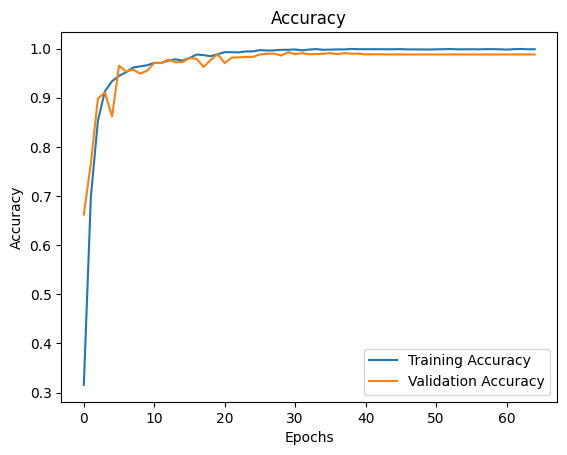

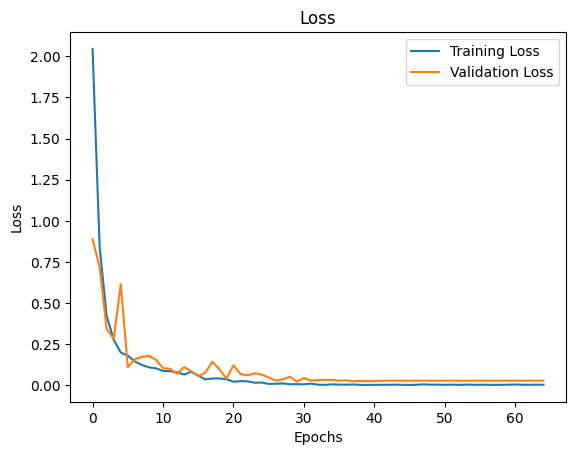

[INFO] Evaluating model...
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step
Final Accuracy: 98.82%


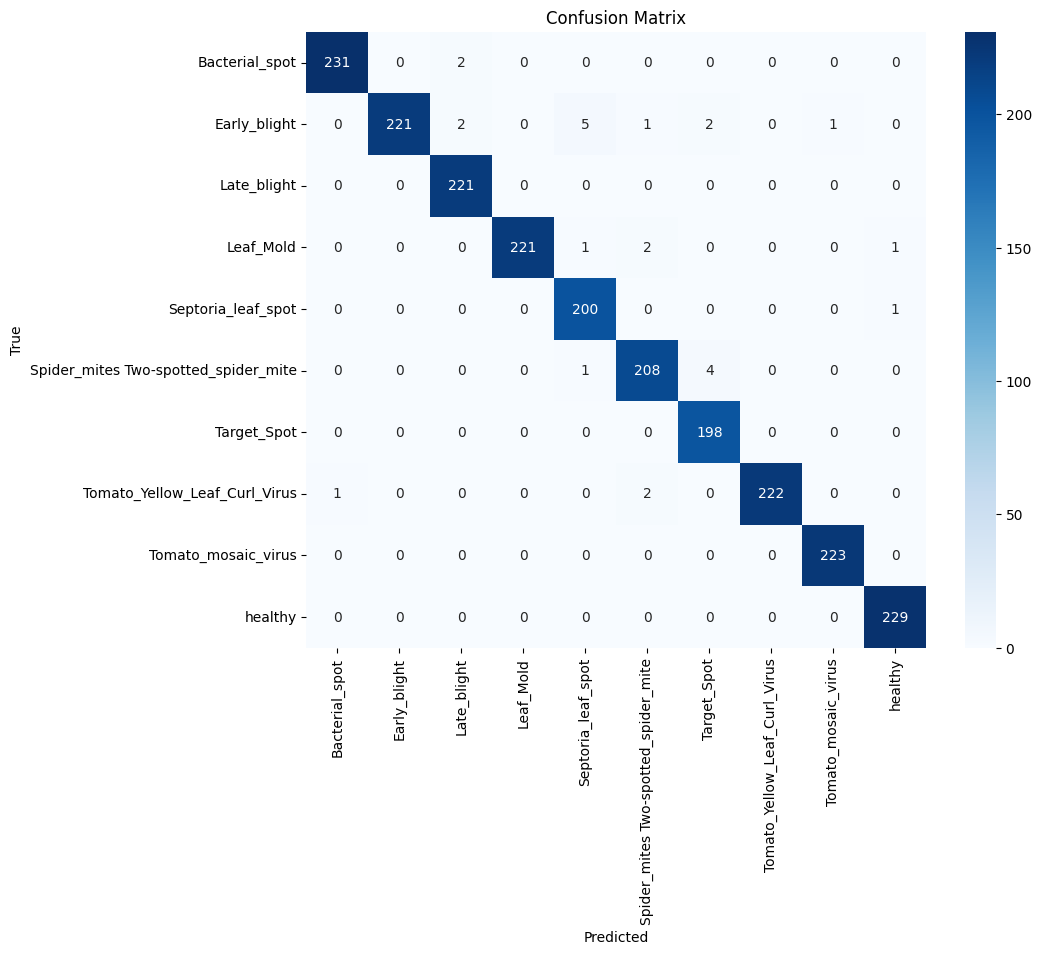

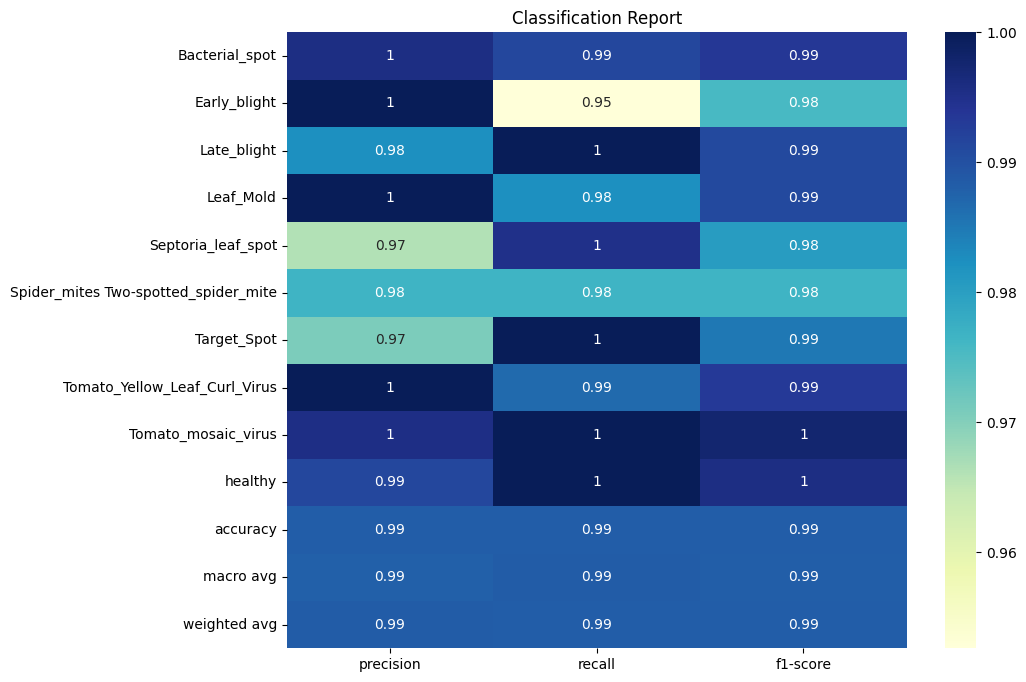

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
TTA Predicted Label: Late_blight


In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Log step messages
def log(message):
    print(f"[INFO] {message}")

# Plot Training Accuracy & Loss
def plot_accuracy(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')  # Save plot
    plt.show()

def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')  # Save plot
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')  # Save plot
    plt.show()

# Classification Report
def plot_classification_report(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='YlGnBu')
    plt.title('Classification Report')
    plt.savefig('classification_report.png')  # Save plot
    plt.show()

# Load dataset
def load_dataset(dataset_path, img_size=(224, 224)):
    X, y = [], []
    for folder in ['train', 'val']:
        folder_path = os.path.join(dataset_path, folder)
        for label in os.listdir(folder_path):
            label_path = os.path.join(folder_path, label)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_name)
                    image = cv2.imread(img_path)
                    if image is not None:
                        image = cv2.resize(image, img_size)
                        X.append(image)
                        y.append(label)
    return np.array(X), np.array(y)

log("Loading dataset...")
dataset_path = "/kaggle/input/tomato/dataset"
X, y = load_dataset(dataset_path)
log(f"Loaded {len(X)} samples.")

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Load Pretrained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-Tune Last 8 Layers
for layer in base_model.layers[:-8]:
    layer.trainable = False

# Custom Model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(np.unique(y_encoded)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Optimizer
optimizer = AdamW(learning_rate=5e-5, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
def cosine_annealing(epoch, lr):
    return lr * (0.5 * (1 + np.cos(np.pi * epoch / 100)))

lr_scheduler = LearningRateScheduler(cosine_annealing)

# Model Training
log("Training model...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32), 
    validation_data=(X_test, y_test), 
    epochs=65, 
    callbacks=[lr_scheduler]
)

# Save Training Results
plot_accuracy(history)
plot_loss(history)

# Model Evaluation
log("Evaluating model...")
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Final Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix & Classification Report
class_names = label_encoder.classes_
plot_confusion_matrix(y_test, y_pred_labels, class_names)
plot_classification_report(y_test, y_pred_labels, class_names)

# Test-Time Augmentation (TTA)
def tta_predict(model, image, tta_rounds=5):
    predictions = []
    for _ in range(tta_rounds):
        aug_img = datagen.random_transform(image)
        predictions.append(model.predict(np.expand_dims(aug_img, axis=0)))
    return np.mean(predictions, axis=0)

# TTA on a Sample Image
sample_img = X_test[0]
tta_prediction = tta_predict(model, sample_img)
tta_label = np.argmax(tta_prediction)

# Save TTA Prediction Image
cv2.imwrite('tta_sample_image.png', sample_img)
print(f"TTA Predicted Label: {label_encoder.classes_[tta_label]}")
